In [1]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import mean_absolute_error
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# Funções

In [2]:
def correct_apac(df_in):
    df_apac = df_in
    df_apac = df_apac[df_apac.dia != "dia"]
    
    df_apac['Datetime']=pd.to_datetime(df_apac.dia.apply(str)+"/"+df_apac.mes.apply(str)+"/"+\
                                       df_apac.ano.apply(str), format="%d/%b/%Y")+\
                                       df_apac['hora(utc)'].apply(lambda x: datetime.timedelta(hours=int(x)))
    
    df_apac.drop(['ano','mes', 'dia', 'hora(utc)'],inplace=True,axis = 1)# drop duplicate infomation
    df_apac.drop_duplicates(subset="Datetime", inplace=True)
    
    inicio = datetime.datetime.strptime("01/"+str(df_apac.Datetime.iloc[0].month)+"/"+\
            str(df_apac.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
    
    fim = df_apac.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    
    #print(len(df_apac), len(df_apac.Datetime.unique()))
    
    df_apac = df_apac.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
        
    return df_apac

def correct_inmet(df_in):
    df_inmet = df_in
    df_inmet.replace('////', np.nan, inplace=True)
    
    columns_to_numeric = list(set(df_inmet.columns) - set(["codigo_estacao","data","hora","planta"]))
    
    df_inmet[columns_to_numeric] = df_inmet[columns_to_numeric].apply(pd.to_numeric)
    df_inmet['Datetime']=pd.to_datetime(df_inmet.data, format="%d/%m/%Y")\
                    +df_inmet.hora.apply(lambda x: datetime.timedelta(hours=x))

    df_inmet.drop(['data','hora'],inplace=True,axis = 1)# drop duplicate infomation
    inicio = datetime.datetime.strptime("01/"+str(df_inmet.Datetime.iloc[0].month)+"/"+\
            str(df_inmet.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
        
    fim = df_inmet.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    df_inmet = df_inmet.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
     
    return df_inmet

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height),
                ha='center', va='bottom')
        
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.01))) * 100  

def mybinconfusionmatrix(y_true, y_pred):
    """        Y_t
              0    1
        p  0  vn  fn
        |   
        Y  1  fp  vp
    """
    confMatrix = np.zeros((2,2))
    vp = 0
    vn = 0
    fp = 0
    fn = 0
    
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i]== 1:
            vp+=1
        if y_true[i] == 1 and y_pred[i]== 0:
            fn+=1
        if y_true[i] == 0 and y_pred[i]== 1:
            fp+=1
        if y_true[i] == 0 and y_pred[i]== 0:
            vn+=1
            
    if vn+fn != 0:
        confMatrix[0,0]=vn/(vn+fn)
        confMatrix[0,1]=fn/(vn+fn)
        
    if vp+fp != 0:
        confMatrix[1,0]=fp/(vp+fp)
        confMatrix[1,1]=vp/(vp+fp)
            
    return confMatrix
            
def indices_performances(y_true, y_pred, thresh=5):
    """y_true - true values\n
    y_pred- predicted valeus\n
    thresh- threshold for binarization
    """
    y_true[y_true>thresh] = 1
    y_true[y_true<thresh] = 0
    
    y_pred[y_pred>thresh] = 1
    y_pred[y_pred<thresh] = 0
    
    M = mybinconfusionmatrix(y_true, y_pred)
    output = {}
    
    a = M[1,1]
    b = M[1,0]
    c = M[0,1]
    d = M[0,0]
    
    if a+b+c+d != 0:
        output["PC"] = (a+d)/(a+b+c+d)
        output["FPR"] = (c+b)/(a+b+c+d)
    else:
        output["PC"] = 0
    if a+c != 0:
        output["POD"] = a/(a+c)
        output["BIAS"] = (a+b)/(a+c)
    else:
        output["POD"] = 0
        output["BIAS"] = 0
    if a+b != 0:
        output["FAR"] = b/(a+b)
    else:
        output["FAR"] = 0
    if a+b+c != 0:
        output["CSI"] = a/(a+b+c)
    else:
        output["CSI"] = 0
    
    
    return output

In [3]:
def plot_and_save_corr_mae_per_variable(df_apac, df_inmet, save_folder, Dict_map_cidades_apac_inmet, 
                                 Dict_map_columns_apac_inmet, qt_days_prv):

    for apac_variable in Dict_map_columns_apac_inmet.keys():
        pearson_corr = []
        maes = []
        inmet_variable = Dict_map_columns_apac_inmet[apac_variable]
        #print(apac_variable)
        
        for apac_point in Dict_map_cidades_apac_inmet.keys():
            #print(apac_point)
            
            inmet_point = Dict_map_cidades_apac_inmet[apac_point]
            
            df_apac = correct_apac(df_apac_total[
                (df_apac_total.planta==apac_point) & (df_apac_total.diasprev == qt_days_prv)])

            df_inmet = correct_inmet(df_inmet_total[df_inmet_total.planta==inmet_point])

            inmet_values = df_inmet.loc[:, inmet_variable].fillna(
                df_inmet[inmet_variable].mean()).astype('float32').values
            
            apac_values = df_apac.loc[:df_inmet.index[-1],:][apac_variable].fillna(
                df_apac.loc[:df_inmet.index[-1],:][apac_variable].mean()).astype('float32').values
            
            
            apac_values = np.nan_to_num(apac_values)
            inmet_values = np.nan_to_num(inmet_values)
            
            corr, twotailed = pearsonr(apac_values, inmet_values)
            maes.append(mean_absolute_error(inmet_values, apac_values))

            pearson_corr.append(corr)
    
        fig, ax1 = plt.subplots(figsize=(16,10))
        
        plt.grid(True, axis="y")

        ax1.set_title(apac_variable, fontsize=18)

        color = 'k'
        tkw = dict(size=6, width=2)
        ax1.set_xlabel('Measurement Points', color=color, fontsize=16)
        ax1.set_ylabel('Correlation', color=color, fontsize=16)
        ax1.bar(Dict_map_cidades_apac_inmet.keys(), pearson_corr, width=0.5, color=color, align='center')
        ax1.tick_params(axis='y', labelcolor='k', **tkw)
        
        min_cor=np.floor(min(pearson_corr))
        max_cor=np.ceil(max(pearson_corr))
        Amp_cor=max(pearson_corr) - min(pearson_corr)
        
        ax1.set_yticks(np.arange(min_cor, max_cor+Amp_cor/5, Amp_cor/5))
        plt.xticks(rotation=45)
        
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'r'
        ax2.set_ylabel('MAE', color=color, fontsize=16)  # we already handled the x-label with ax1
        ax2.scatter(Dict_map_cidades_apac_inmet.keys(), maes, color=color)
        ax2.tick_params(axis='y', labelcolor=color, **tkw)
        
        min_maes=np.floor(min(maes))
        max_maes=np.ceil(max(maes))
        Amp_maes=max(maes) - min(maes)
        
        ax2.set_yticks(np.arange(min_maes, max_maes+Amp_maes/5, Amp_maes/5))
        
        savename = save_folder + '\\'+'correlation_mae_'+apac_variable+ "_"+ str(qt_days_prv)+'.png'

        plt.savefig(savename, dpi=300)

In [11]:
def plot_analise_chuva(df_apac, df_inmet, save_folder, Dict_map_cidades_apac_inmet, 
                                 map_chuva, qt_days_prv, freq="1D", tresh=5):
    """
    freq = ["ND" - N<30] or None
    """
    
    def make_patch_spines_invisible(ax):
            ax.set_frame_on(True)
            ax.patch.set_visible(False)
            for sp in ax.spines.values():
                sp.set_visible(False)
    
    for apac_variable in map_chuva.keys():
        performances = []
        inmet_variable = map_chuva[apac_variable]
        #print(apac_variable)
        
        apac_points = Dict_map_cidades_apac_inmet.keys()
        
        for apac_point in apac_points:
            #print(apac_point)
            inmet_point = Dict_map_cidades_apac_inmet[apac_point]

            df_apac = correct_apac(df_apac_total[
                (df_apac_total.planta==apac_point) & (df_apac_total.diasprev == qt_days_prv)])

            df_inmet = correct_inmet(df_inmet_total[df_inmet_total.planta==inmet_point])
            
            if freq == None:
                inmet_values = df_inmet.loc[:, inmet_variable].fillna(
                    df_inmet[inmet_variable].mean()).astype('float32').values

                apac_values = df_apac.loc[:df_inmet.index[-1],:][apac_variable].fillna(
                    df_apac.loc[:df_inmet.index[-1],:][apac_variable].mean()).astype('float32').values
            
            else:
                grouped_inmet = df_inmet.groupby(pd.Grouper(key='index', freq=freq)).sum()
                inmet_values = grouped_inmet.loc[:,inmet_variable].values
                grouped_apac = df_apac.groupby(pd.Grouper(key='index', freq=freq)).sum()
                apac_values = grouped_apac.loc[:grouped_inmet.index[-1],apac_variable].values
            
            apac_values = np.nan_to_num(apac_values)
            inmet_values = np.nan_to_num(inmet_values)
            
            performance = indices_performances(apac_values, inmet_values, 1)
            performances.append(performance)
        
        
        # Sorting by PC
        
        PC = np.array(list(map(lambda d: d["PC"], performances)))
        argsort = PC.argsort()
        PC = PC[argsort]
        POD = np.array(list(map(lambda d: d["POD"], performances)))[argsort]
        FAR = np.array(list(map(lambda d: d["FAR"], performances)))[argsort]
        CSI = np.array(list(map(lambda d: d["CSI"], performances)))[argsort]
        BIAS = np.array(list(map(lambda d: d["BIAS"], performances)))[argsort]
        xlabels = np.array(list(apac_points))[argsort]
        
        fig, host = plt.subplots(figsize=(20,15))
        
        # Metricas de performance
        #################################################
        host.set_title("Perfomance Chuva", fontsize=20)

        par1 = host.twinx()
        par2 = host.twinx()
        par3 = host.twinx()
        par4 = host.twinx()

        # Offset the right spine of par2.  The ticks and label have already been
        # placed on the right by twinx above.
        par2.spines["right"].set_position(("axes", 1.07))
        par3.spines["right"].set_position(("axes", 1.14))
        par4.spines["right"].set_position(("axes", 1.21))
        # Having been created by twinx, par2 has its frame off, so the line of its
        # detached spine is invisible.  First, activate the frame but make the patch
        # and spines invisible.
        make_patch_spines_invisible(par2)
        make_patch_spines_invisible(par3)
        make_patch_spines_invisible(par4)
        # Second, show the right spine.
        par2.spines["right"].set_visible(True)
        par3.spines["right"].set_visible(True)
        par4.spines["right"].set_visible(True)
        
        colors=["b","r","g","k","m"]
        
        p1, = host.plot(xlabels, PC, c=colors[0], linewidth=3, marker="*", markersize=15, label="PC")
        p2, = par1.plot(xlabels, POD, c=colors[1], linewidth=3, marker=".", markersize=15, label="POD")
        p3, = par2.plot(xlabels, FAR, c=colors[2], linewidth=3, marker="P", markersize=15, label="FAR")
        p4, = par3.plot(xlabels, CSI, c=colors[3], linewidth=3, marker="<", markersize=15, label="CSI")
        p5, = par4.plot(xlabels, BIAS, c=colors[4], linewidth=3, marker="d", markersize=15, label="BIAS")

        host.set_xlabel("Measurement Points", fontsize=16)
        host.set_ylabel("Proporção Correta", fontsize=16)
        par1.set_ylabel("Probabilidade de Detecção", fontsize=16)
        par2.set_ylabel("Taxa de Alarme Falso", fontsize=16)
        par3.set_ylabel("Índice de Sucesso Crítico", fontsize=16)
        par4.set_ylabel("Taxa de Tendência", fontsize=16)

        host.yaxis.label.set_color(colors[0])
        par1.yaxis.label.set_color(colors[1])
        par2.yaxis.label.set_color(colors[2])
        par3.yaxis.label.set_color(colors[3])
        par4.yaxis.label.set_color(colors[4])

        tkw = dict(size=14, width=2, labelsize=16)
        host.tick_params(axis='y', colors=colors[0], **tkw)
        par1.tick_params(axis='y', colors=colors[1], **tkw)
        par2.tick_params(axis='y', colors=colors[2], **tkw)
        par3.tick_params(axis='y', colors=colors[3], **tkw)
        par4.tick_params(axis='y', colors=colors[4], **tkw)
        host.tick_params(axis='x', rotation=45, **tkw)
        
        host.grid(True, axis="both")
        
        lines = [p1, p2, p3, p4, p5]

        host.legend(lines, [l.get_label() for l in lines], fontsize=16, loc="upper left")
        savename = save_folder + '\\'+'performance_'+apac_variable+ "_"+ str(qt_days_prv)+'.png'
        plt.savefig(savename, dpi=300, bbox_inches='tight')

# Métricas

## Variáveis

In [5]:
Dict_map_cidades_apac_inmet = {"Coremas":"coremas","Aquiraz":"aquiraz","Assu":"assu","Barreiras":"barreiras",
                               "BJLapaI":"bomjesusdalapa","BJLapaII":"bomjesusdalapa",
                                "BJLapaIII":"bomjesusdalapa","BJLapaIV":"bomjesusdalapa",
                                "Juazeiro":"juazeiro","Mossoro":"mossoro","Quixere":"quixere",
                                "SGGurgeia":"sggurgeias","SJPiaui":"sjpiaui","TabocasI":"tabocas",
                                "TabocasII":"tabocas","Tacaratu":"tacaratu", "Petrolina":"tacaratu",
                              "Arco_Verde":"arcoverde","Cabrobo":"cabrobo", "Floresta":"floresta",
                               "Garanhuns":"garanhuns","Ibimirim":"ibimirim","Recife":"recife","Salgueiro":"salgueiro",
                              "Surubim":"surubim","Palmares":"palmares", "Ouricuri":"ouricuri",
                               "Serra_Talhada":"serratalhada"}

map_columns_apac_inmet_corr_mae = {"temperatura":"temp_inst","umidade":"umid_inst","pontodeorvalho":"pto_orvalho_inst",
                                "pressao":"pressao","VVel":"vento_vel","Vdir":"vento_direcao",
                                "Irradiacao":"radiacao"}

map_chuva = {"chuva":"precipitacao"}

qt_days_prv = 1

## Abril

C:\Users\hugow\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\hugow\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


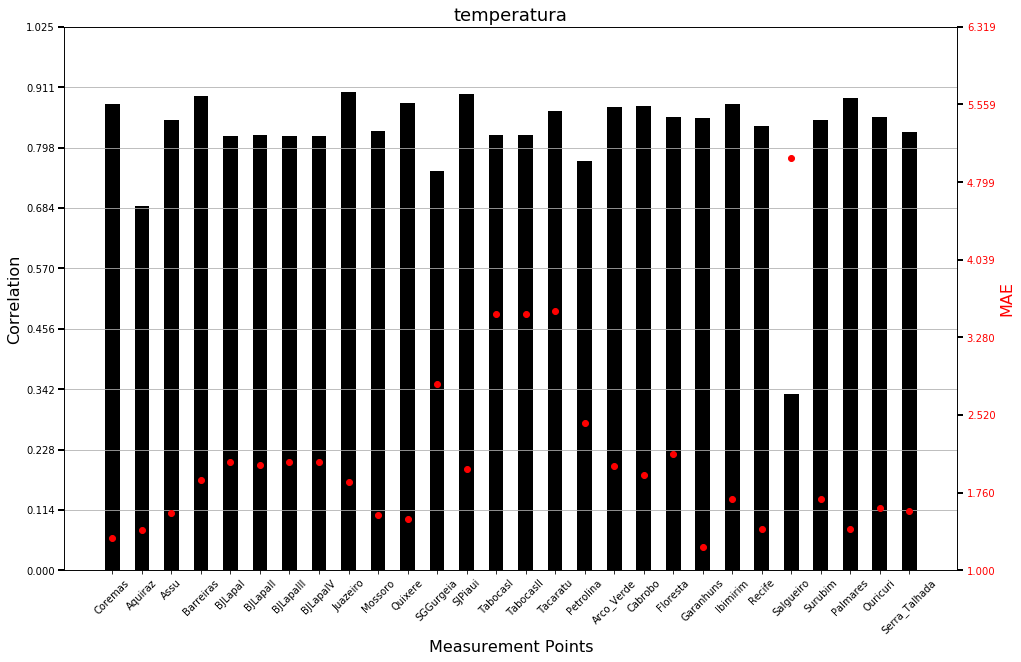

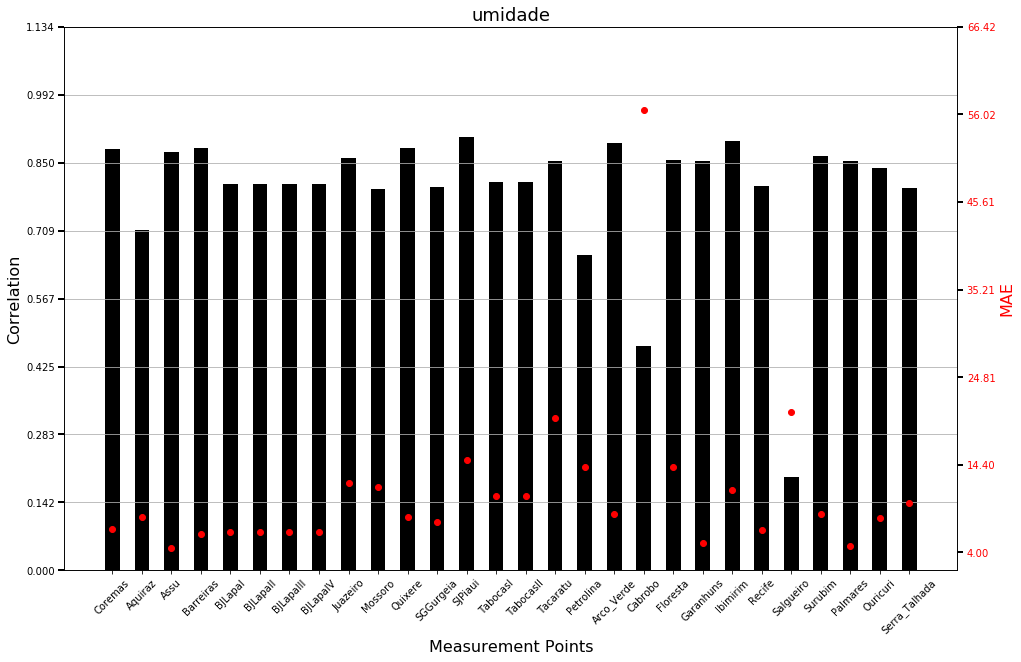

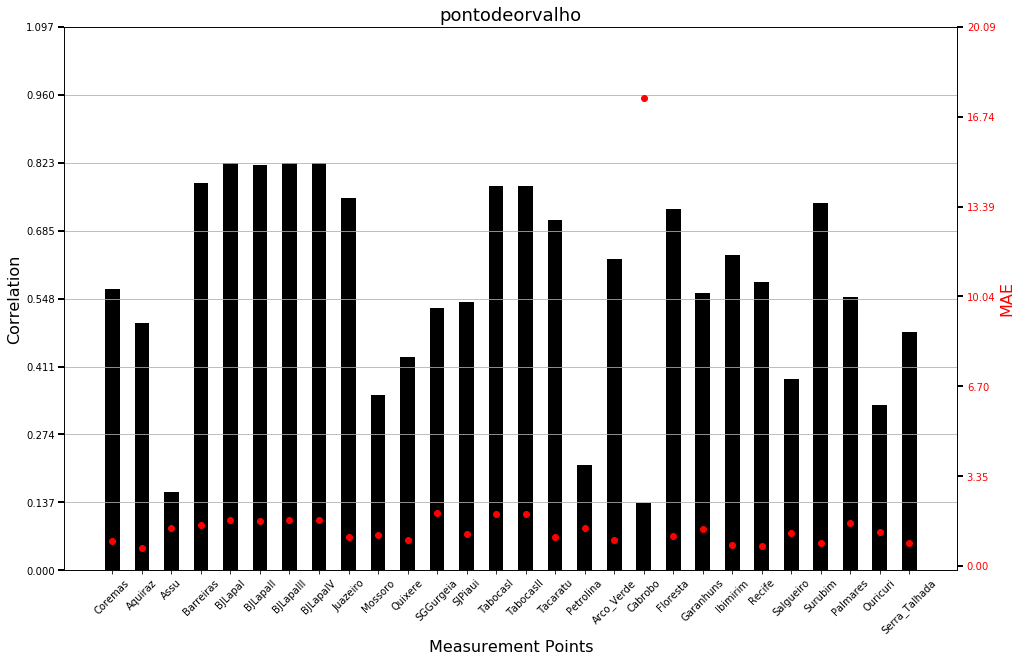

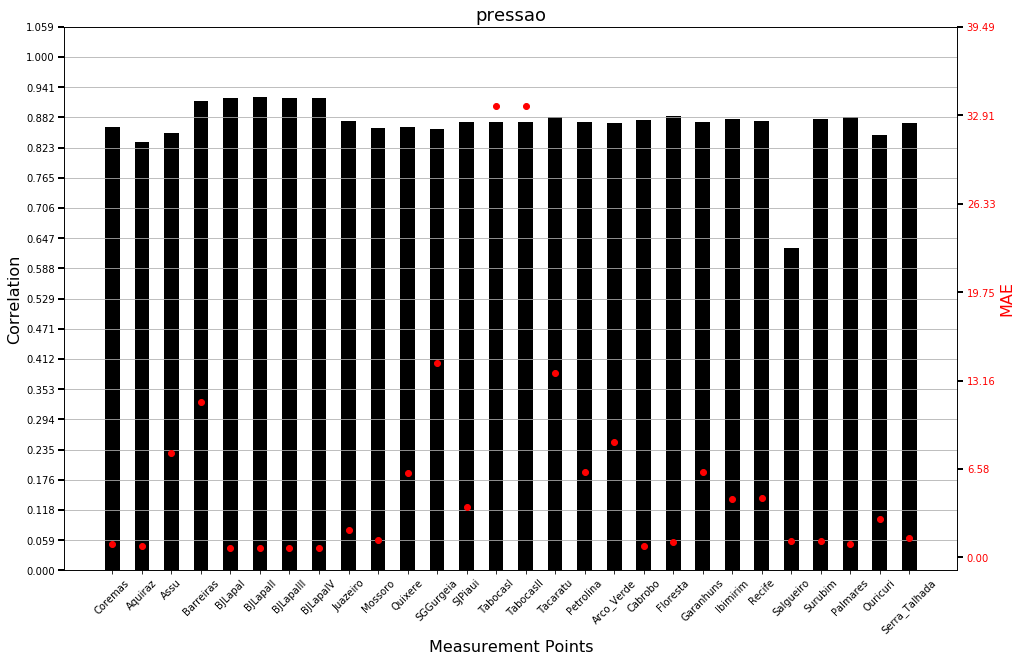

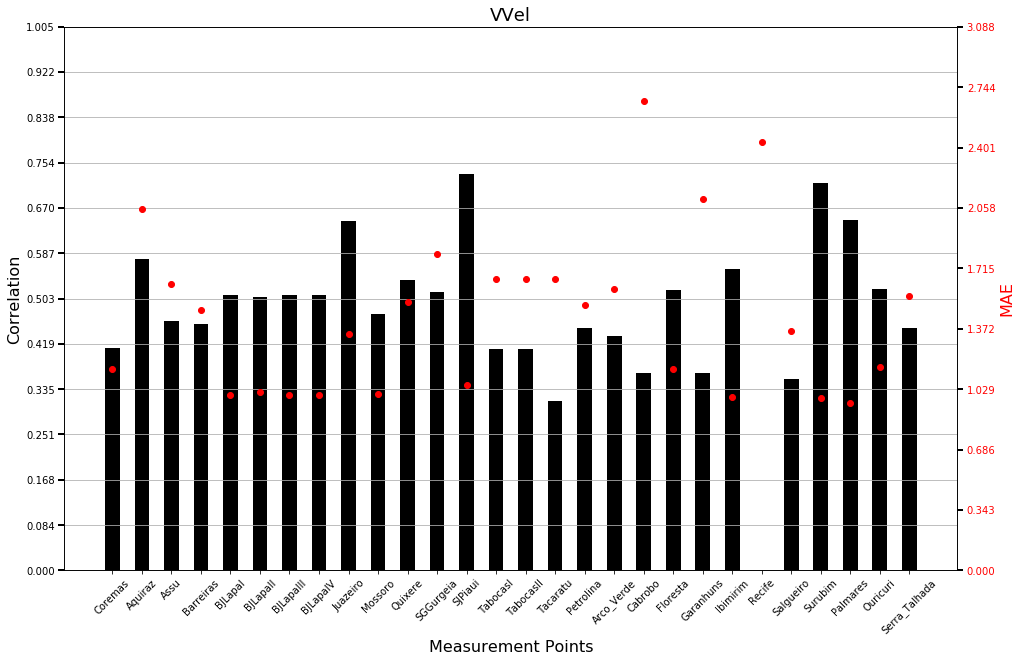

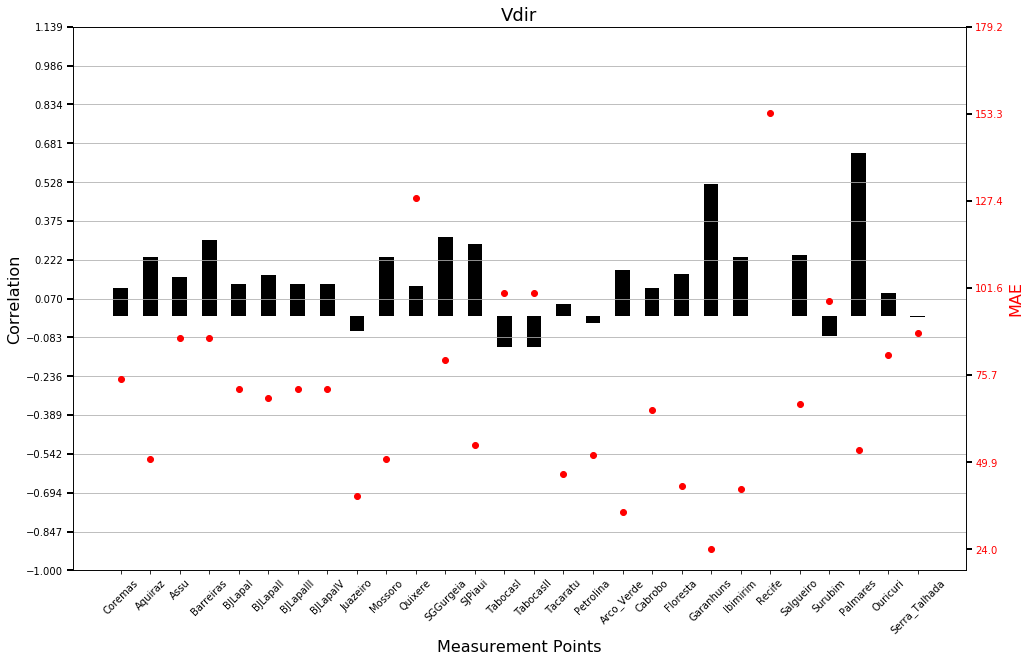

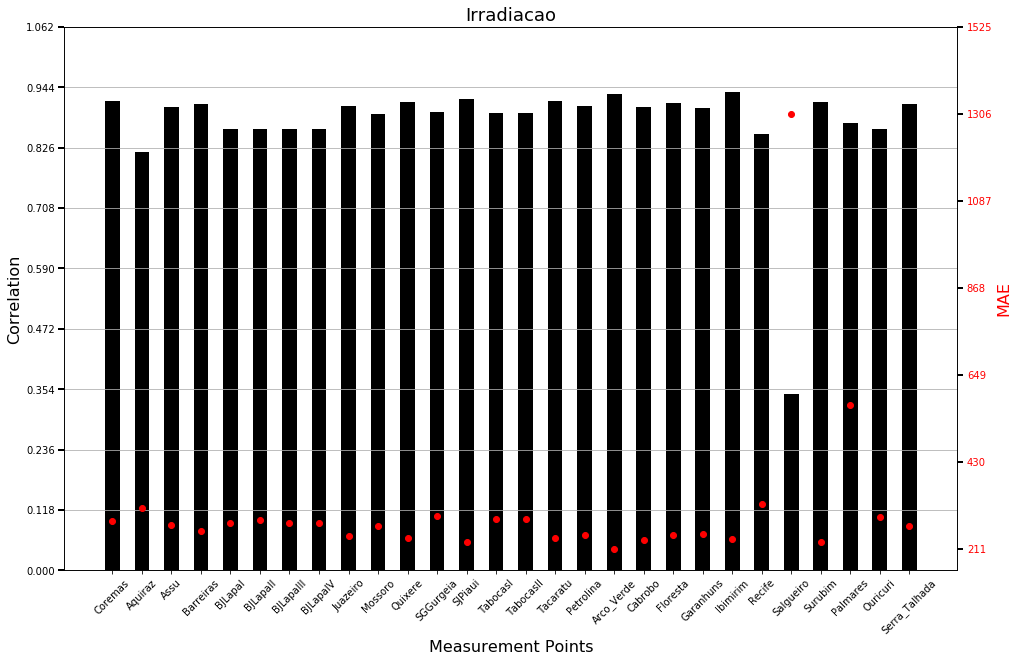

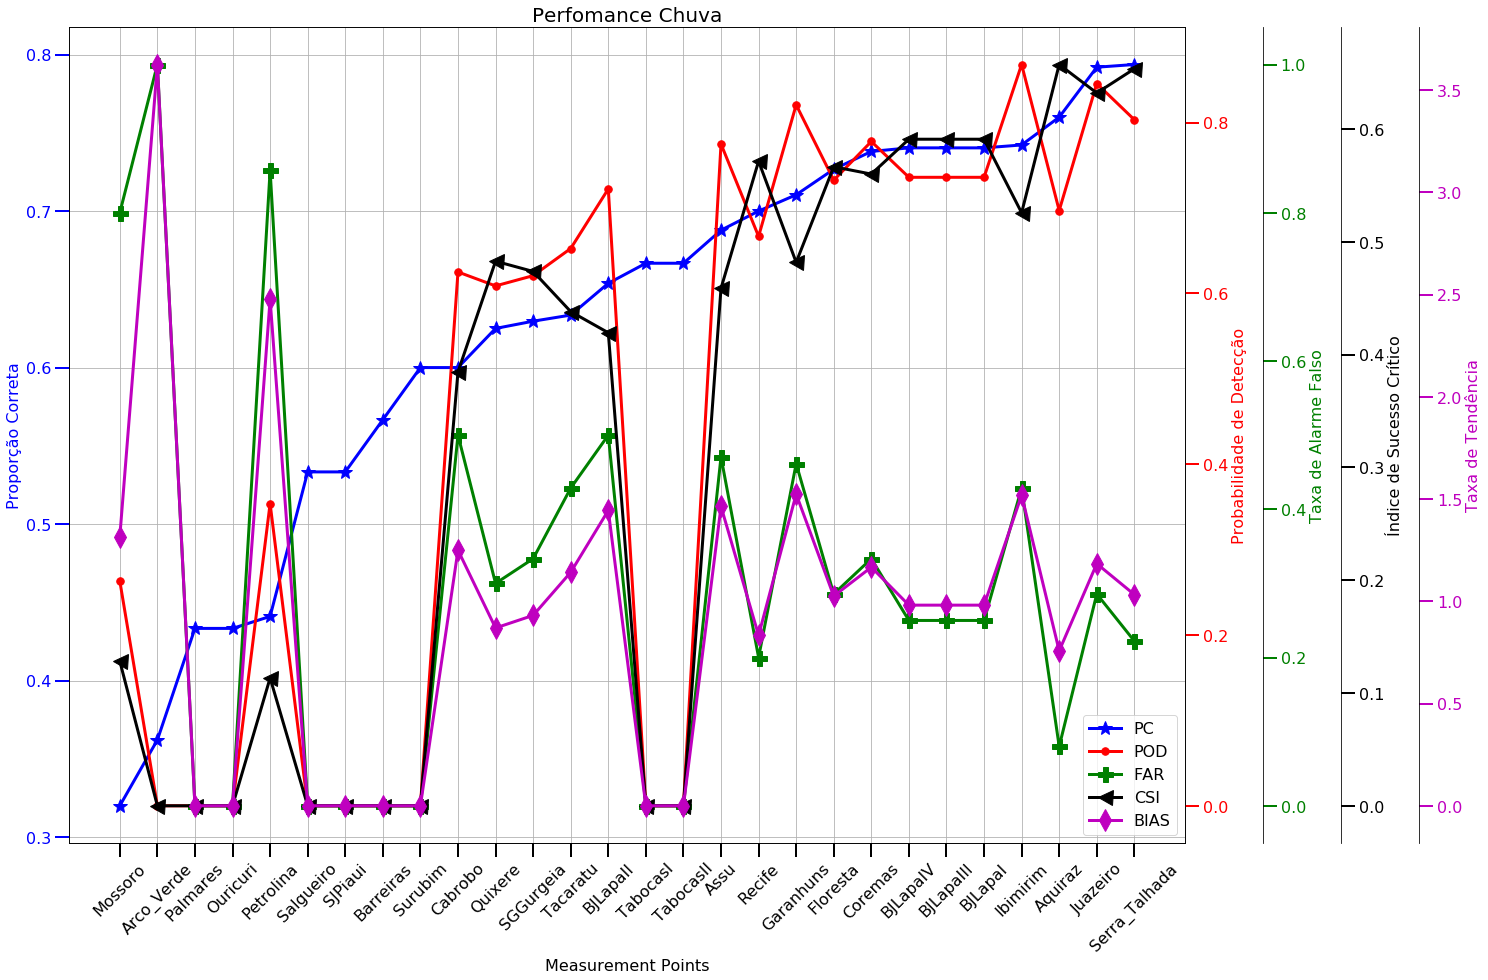

In [6]:
apac_csv = '.\APAC_Data\Abril_WRF_APAC.csv'
inmet_csv = '.\INMET_Data\Abril_INMET.csv'

save_folder = "metrics/abril"

df_apac_total = pd.read_csv(apac_csv, sep=';', encoding = "ISO-8859-1")
df_inmet_total = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

os.makedirs(save_folder, exist_ok=True)

plot_and_save_corr_mae_per_variable(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
                             map_columns_apac_inmet_corr_mae, qt_days_prv)

plot_analise_chuva(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
                   map_chuva, qt_days_prv,freq="1D", tresh=5)

## Maio

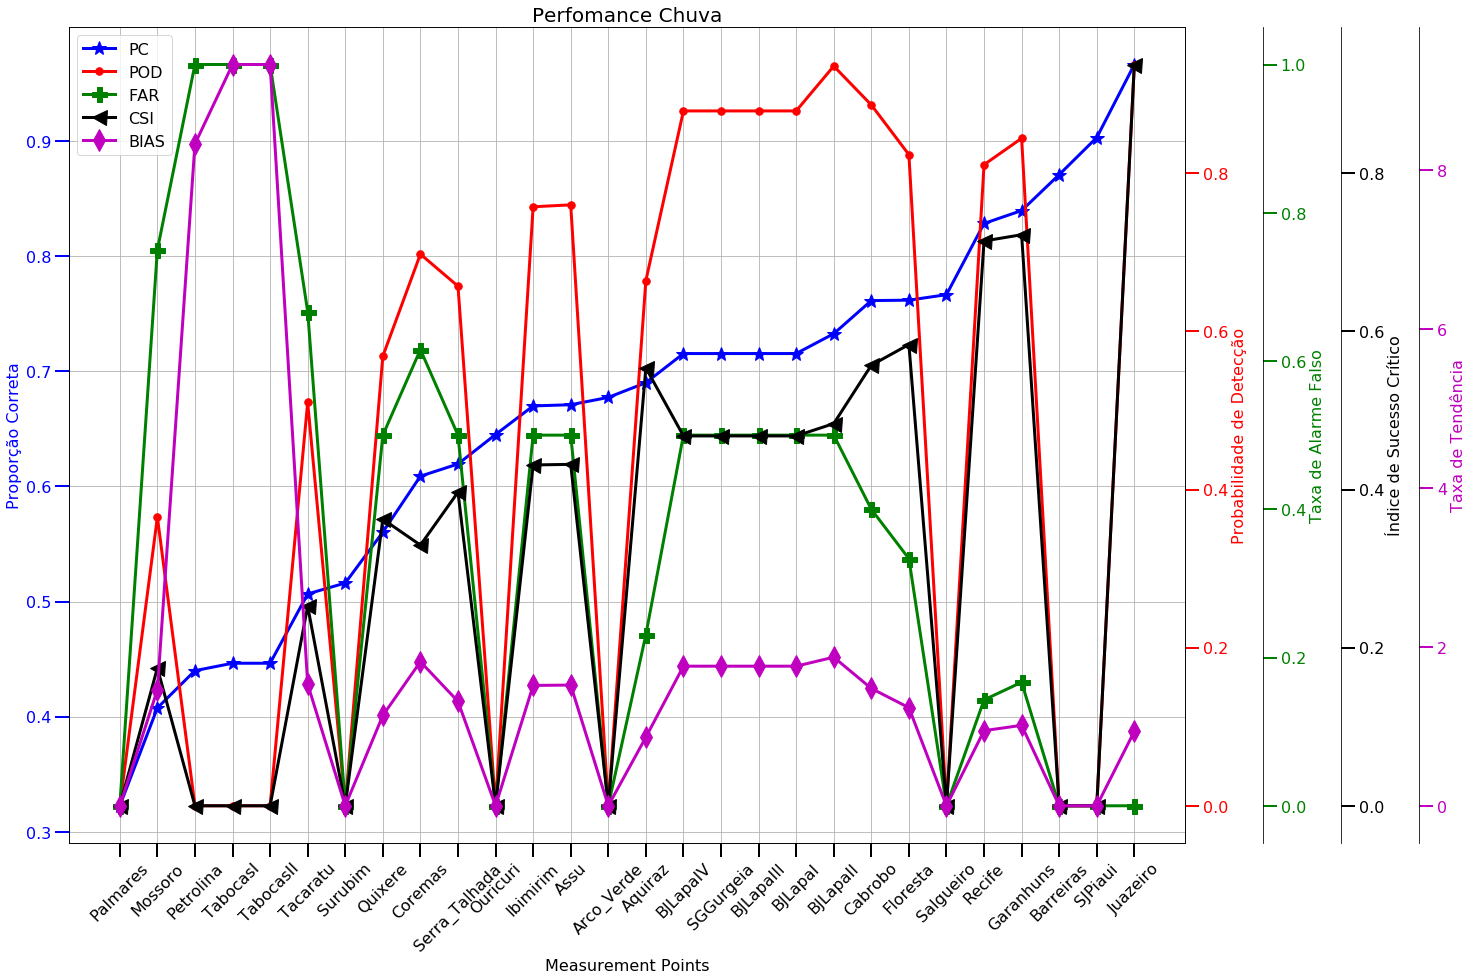

In [12]:
apac_csv = '.\APAC_Data\Maio_WRF_APAC.csv'
inmet_csv = '.\INMET_Data\Maio_INMET.csv'

save_folder = "metrics/maio"

df_apac_total = pd.read_csv(apac_csv, sep=';', encoding = "ISO-8859-1")
df_inmet_total = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

os.makedirs(save_folder, exist_ok=True)


# plot_and_save_corr_mae_per_variable(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
#                              map_columns_apac_inmet_corr_mae, qt_days_prv)

plot_analise_chuva(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
                   map_chuva, qt_days_prv,freq="1D", tresh=5)

# Todos os Meses

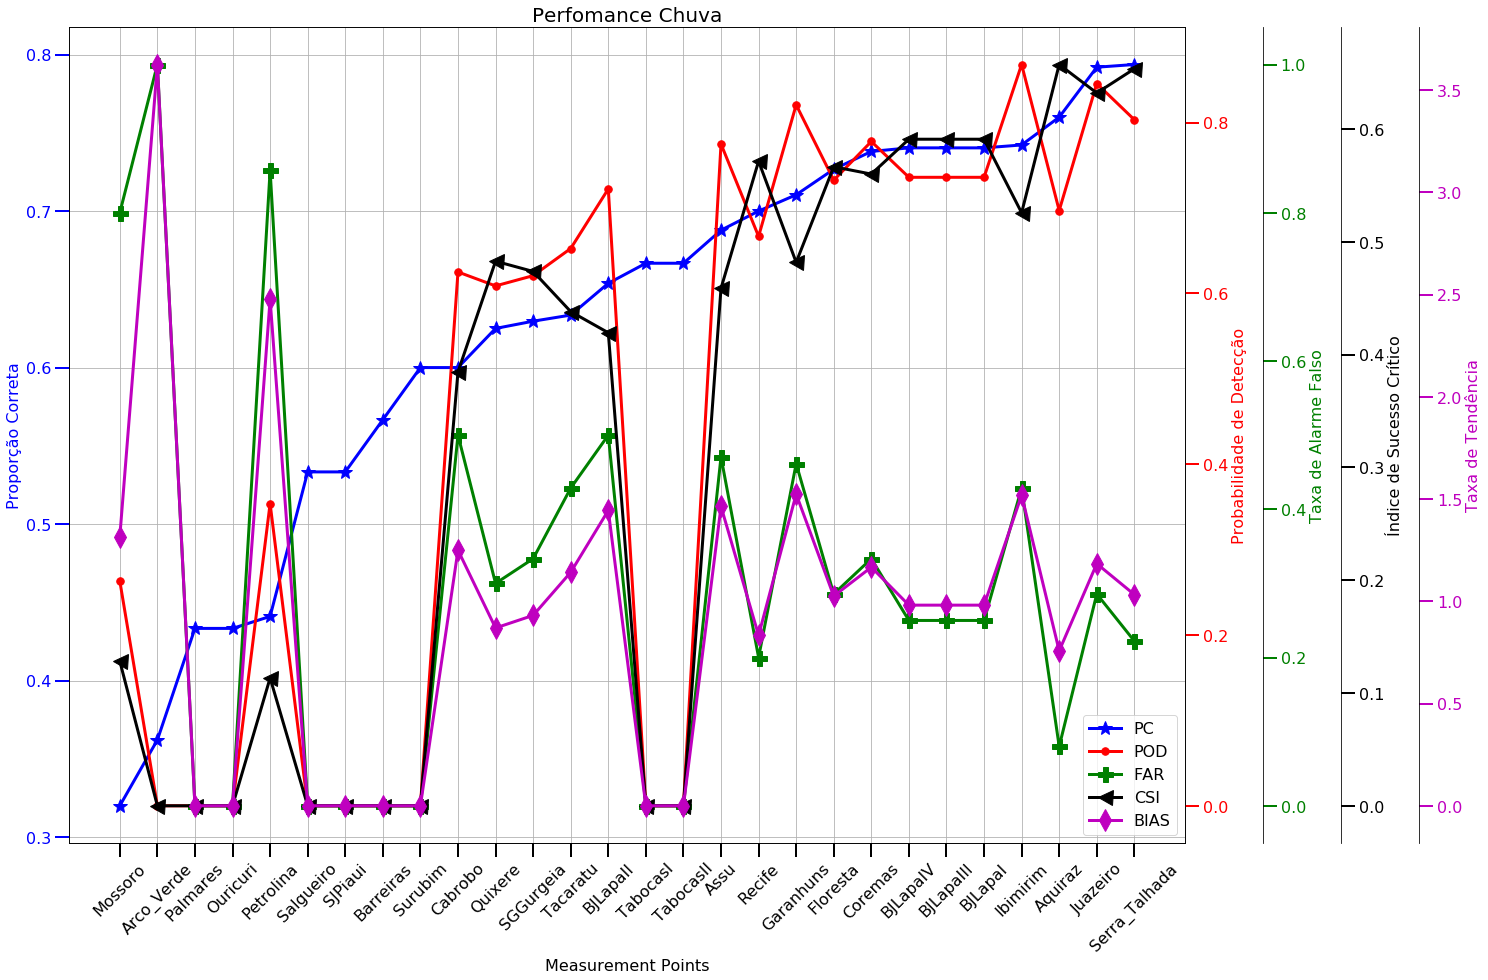

In [8]:
apac_csvs = ['.\APAC_Data\Abril_WRF_APAC.csv', '.\APAC_Data\Maio_WRF_APAC.csv']
inmet_csvs = ['.\INMET_Data\Abril_INMET.csv','.\INMET_Data\Maio_INMET.csv']

save_folder = "metrics/all"

os.makedirs(save_folder, exist_ok=True)

df_apac_total = pd.read_csv(apac_csvs[0], sep=';', encoding = "ISO-8859-1")

for dfs_count in range(1, len(apac_csvs)):
    df_apac_total = df_apac_total.append(pd.read_csv(apac_csvs[dfs_count], sep=';', encoding = "ISO-8859-1"))

df_inmet_total = pd.read_csv(inmet_csvs[0], sep=',', encoding = "ISO-8859-1")

for dfs_count in range(1, len(apac_csvs)):
    df_inmet_total = df_inmet_total.append(pd.read_csv(inmet_csvs[dfs_count], sep=';', encoding = "ISO-8859-1"))


# plot_and_save_corr_mae_per_variable(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
#                              map_columns_apac_inmet_corr_mae, qt_days_prv)

plot_analise_chuva(df_apac_total, df_inmet_total, save_folder, Dict_map_cidades_apac_inmet,
                   map_chuva, qt_days_prv, freq="1D", tresh=5)